# my_database_script
Here I will create some basic plots for my_database. The idea of this notebook is to get an overview of the data, which comes directly from the DTS device, without processesing. If you are new to DTS in Alsdorf this notebook is a good start. For further analysis take a look at other notebooks.

In [1]:
#######Input###############
path_DTS_processed = r"..\Alsdorf\Daten\DTS_processed"
import_type = "pickle" # "csv" "pickle"
plot_save = True    # True False
check = True # True False # some checks of the data, e.g. nan values
plot_2018_data = True # True False
############################
masterthesis_save = False #True False

In [2]:
# Load packages
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from collections import defaultdict
import glob
from collections import Counter
import matplotlib.patches as patches
import matplotlib.dates as mdates
from shutil import copy2 as copy_file
from matplotlib import colors
from datetime import date, timedelta

# import functions for importing data
from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_2018_pickle, import_my_database_csv, import_my_database_2018_csv, merge_data_year, import_complete_database
# import functions for measurements per day calculations
from my_func_mvw.functions_measurements_per_day import all_days_of_year, calculate_measurements_per_day, improve_n_meas_pday
# various other functions
from my_func_mvw.functions import get_abspath, calc_mean_channels_n_pday, read_pickle
%load_ext autoreload
%autoreload 2

print("Some Version information of the imported packages")
print(f"pandas: {pd.__version__}")
print(f"pickle: {pickle.format_version}")
!python --version

Some Version information of the imported packages
pandas: 1.3.5
pickle: 4.0
Python 3.8.12


# Import Data

In [3]:
# 23 s
# Load pickle data
if import_type == "pickle":
    # Load Data 2019+
    path_to_my_database_pickle = path_DTS_processed + r"\pickle"

    data_seperated_by_year=import_complete_database(path_to_my_database_pickle,importer=import_type,controller=3188)

    path_to_my_database_2018_pickle=path_DTS_processed + r"\temp_2018_Controller3188\pickle"
    data_seperated_by_year["2018"] = import_my_database_2018_pickle(path_to_my_database_2018_pickle) #in the next cell it is expected to have 2018 as last entry

# 1min 40s
# Load csv data
elif import_type == "csv":
    path_to_my_database_csv = path_DTS_processed + r"\csv"

    data_seperated_by_year=import_complete_database(path_to_my_database_csv,importer=import_type,controller=3188)

    path_to_my_database_2018_csv = path_DTS_processed + r"\temp_2018_Controller3188\csv"
    data_seperated_by_year["2018"] = import_my_database_2018_csv(path_to_my_database_2018_csv) #in the next cell it is expected to have 2018 as last entry

In [4]:
# Merge the different years (2019+) dics into one
if import_type == "pickle":
    data_all = read_pickle(path_DTS_processed + "\import_data_scripts\data_all")
elif import_type == "csv": # 30s
    data_all = merge_data_year([data_seperated_by_year[i] for i in list(data_seperated_by_year.keys())[:-1]]) #without 2018 data

# Plot data - 2019+

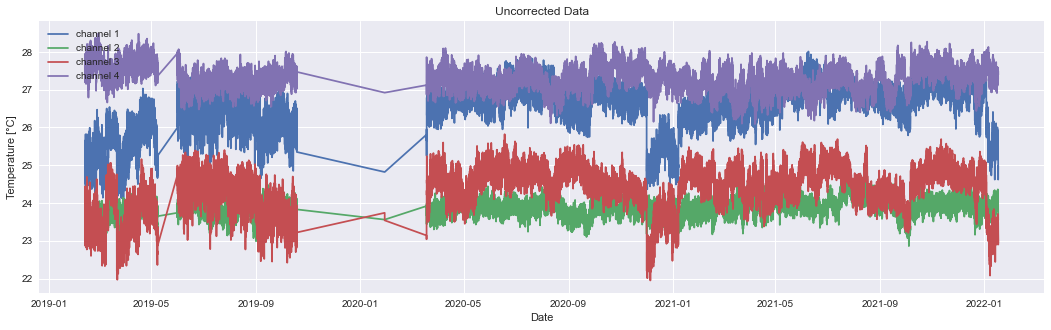

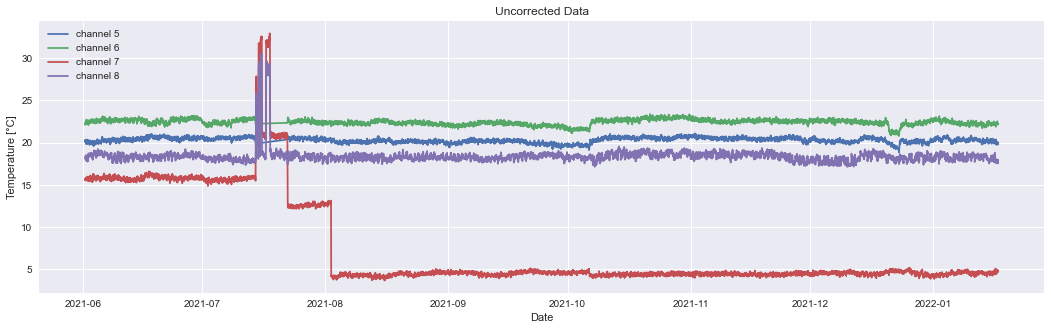

In [5]:
# Plot uncorrected data
length=450 # change me
plt.figure(figsize=(18,5))
for c in ["1","2","3","4"]:
    inde=data_all[c][length].index
    val=data_all[c][length].values
    plt.plot(inde,val, label=f"channel {c}")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.title("Uncorrected Data")
plt.legend(loc="upper left") # with large amount of data loc="best" can be slow
# plt.ylim(22,29)
plt.show()

length=600 # change me
plt.figure(figsize=(18,5))
for c in ["5","6","7","8"]:
    inde=data_all[c][length].index
    val=data_all[c][length].values
    plt.plot(inde,val, label=f"channel {c}")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.title("Uncorrected Data")
plt.legend(loc="upper left") # with large amount of data loc="best" can be slow
# plt.ylim(22,29)
plt.show()

# nach neuem Quick-Start können sich die Kalibration im Gerät anscheinend stark ändern (Kanal 7). Siehe auch Plot für CH 1-4

In [6]:
show_elisas_plot=False
if show_elisas_plot: # Plot I made for Elisa
    # daten im wasser angegcukt (Schacht), da dort die temp relativ konst (zeitlich) sein sollte
    length=450 # you can change it
    from_date=0#25000
    to_date=-1
    fig, axs = plt.subplots(figsize=(18,5))
    for c in ["1","2","3","4"]:
        inde=data_all[c][length].index[from_date:to_date]
        val=data_all[c][length].values[from_date:to_date]
        axs.plot(inde,val, label=f"channel {c}")
    axs.vlines(pd.to_datetime("2020-11-24 12:00:00"),22,29,color="black",label="Wireline")
    #axs.set_xlabel("Date")

    font=20
    axs.set_ylabel("Temperature [°C]",fontsize=font)
    #axs.set_xlabel("Date",fontsize=16)
    axs.set_title(f"Uncorrected Data 1-4; Length: {length} m",fontsize=font)
    axs.tick_params(axis='x', which='major', labelsize=font-2, labelrotation=15)
    axs.tick_params(axis='y', which='major', labelsize=font-2, labelrotation=0)
    legend = axs.legend(fontsize=font-4, frameon=True)
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor("white")

    #plt.savefig("pictures/ch1-4_uncorrected_alldates.png", dpi=720, bbox_inches="tight")

# Measurements per day calculation

In [7]:
# To-Do - alles nicht so wichtig
# Im Plot am Ende genaues Datum markieren, ab dem es kaum Daten gibt
# evntl markante Datenpunkte mithilfe von (rotem) Punkt markieren und label / patch dran machen
# Heizperiode einfügen?

#count the number of measurements per day; at the moment missing days are not printed
n_meas_pday={}
for year in data_seperated_by_year.keys():
    if year!="2018": #treated seperatly further down
        print(year)
        n_meas_pday[year]=calculate_measurements_per_day(data_seperated_by_year[year])
        print()

# Improve n_meas_pdy: add days where 0 measurements were made
# days with 0 measurements will occur in the new dictionaries
n_meas_pday_with0={}
for year in data_seperated_by_year.keys():
    if year!="2018": #treated seperatly further down
        n_meas_pday_with0[year]=improve_n_meas_pday(n_meas_pday[year], int(year))

2019

2020

2021

2022



In [8]:
# Calculate mean measurements per day per channel
mean_n_day={}; date_n_day={}
for year in data_seperated_by_year.keys():
    if year!="2018": #treated seperatly further down
        mean_n_day[year], date_n_day[year] = calc_mean_channels_n_pday(n_meas_pday_with0[year], channels=["1","2","3","4","5","6","7","8"])

# Plot Measurements per day

In [9]:
def plot_save_func(filename_save):
    """saves the plots as png and copies them to my_database"""
    save_path = "pictures/" + filename_save + ".png"
    plt.savefig(save_path)

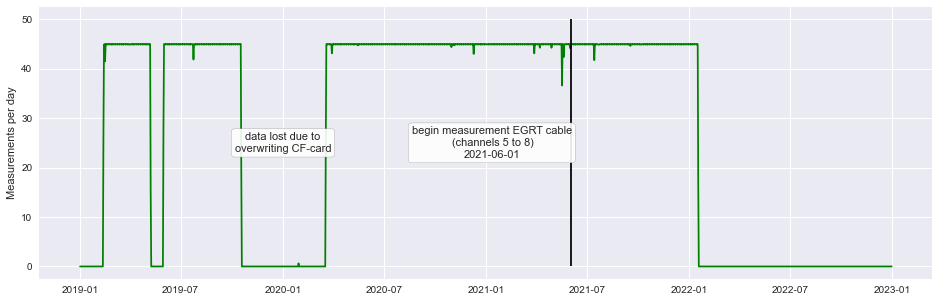

In [10]:
#Plot mean measurements per channel

plt.figure(figsize=[16,5])
# plt.plot(date_2019, mean_2019,color="green")
# plt.plot(date_2020, mean_2020,color="green")
# plt.plot(date_2021, mean_2021,color="green")
# plt.plot(date_2022, mean_2022,color="green")

for year in data_seperated_by_year.keys():
    if year!="2018": #treated seperatly further down
        plt.plot(date_n_day[year], mean_n_day[year],color="green")

plt.ylabel("Measurements per day")
#plt.xlabel("Date")
#plt.title(f"Mean of Channels 1 - 8")

# PLOT ACCESSOIREs, Plot Patches with description
## some generel settings
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=11; y=25; ha="center"; va="center"
x=mdates.date2num(pd.to_datetime("01.01.2020"))
plt.text(x, y,"data lost due to\noverwriting CF-card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box
# Add Patch at begin of measurement of EGRT cable (channel 5-8)
x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')) #date of first measurement of EGRT Cable
ymax=max(np.concatenate([mean_n_day[year] for year in mean_n_day.keys()])) + 5
plt.vlines(x, ymin=0, ymax=ymax, colors="black",linestyles="-")
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')- timedelta(days=142)) 
plt.text(x, y,"begin measurement EGRT cable\n (channels 5 to 8)\n2021-06-01", ha=ha, va=va, size=size, bbox=bbox_props)

if plot_save:
    plot_save_func("mean_of_all_channels_measpday")
    if masterthesis_save:# save for my masterthesis
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\mean_of_all_channels_measpday.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\mean_of_all_channels_measpday.png", format="png",bbox_inches="tight",dpi=300)

plt.show()

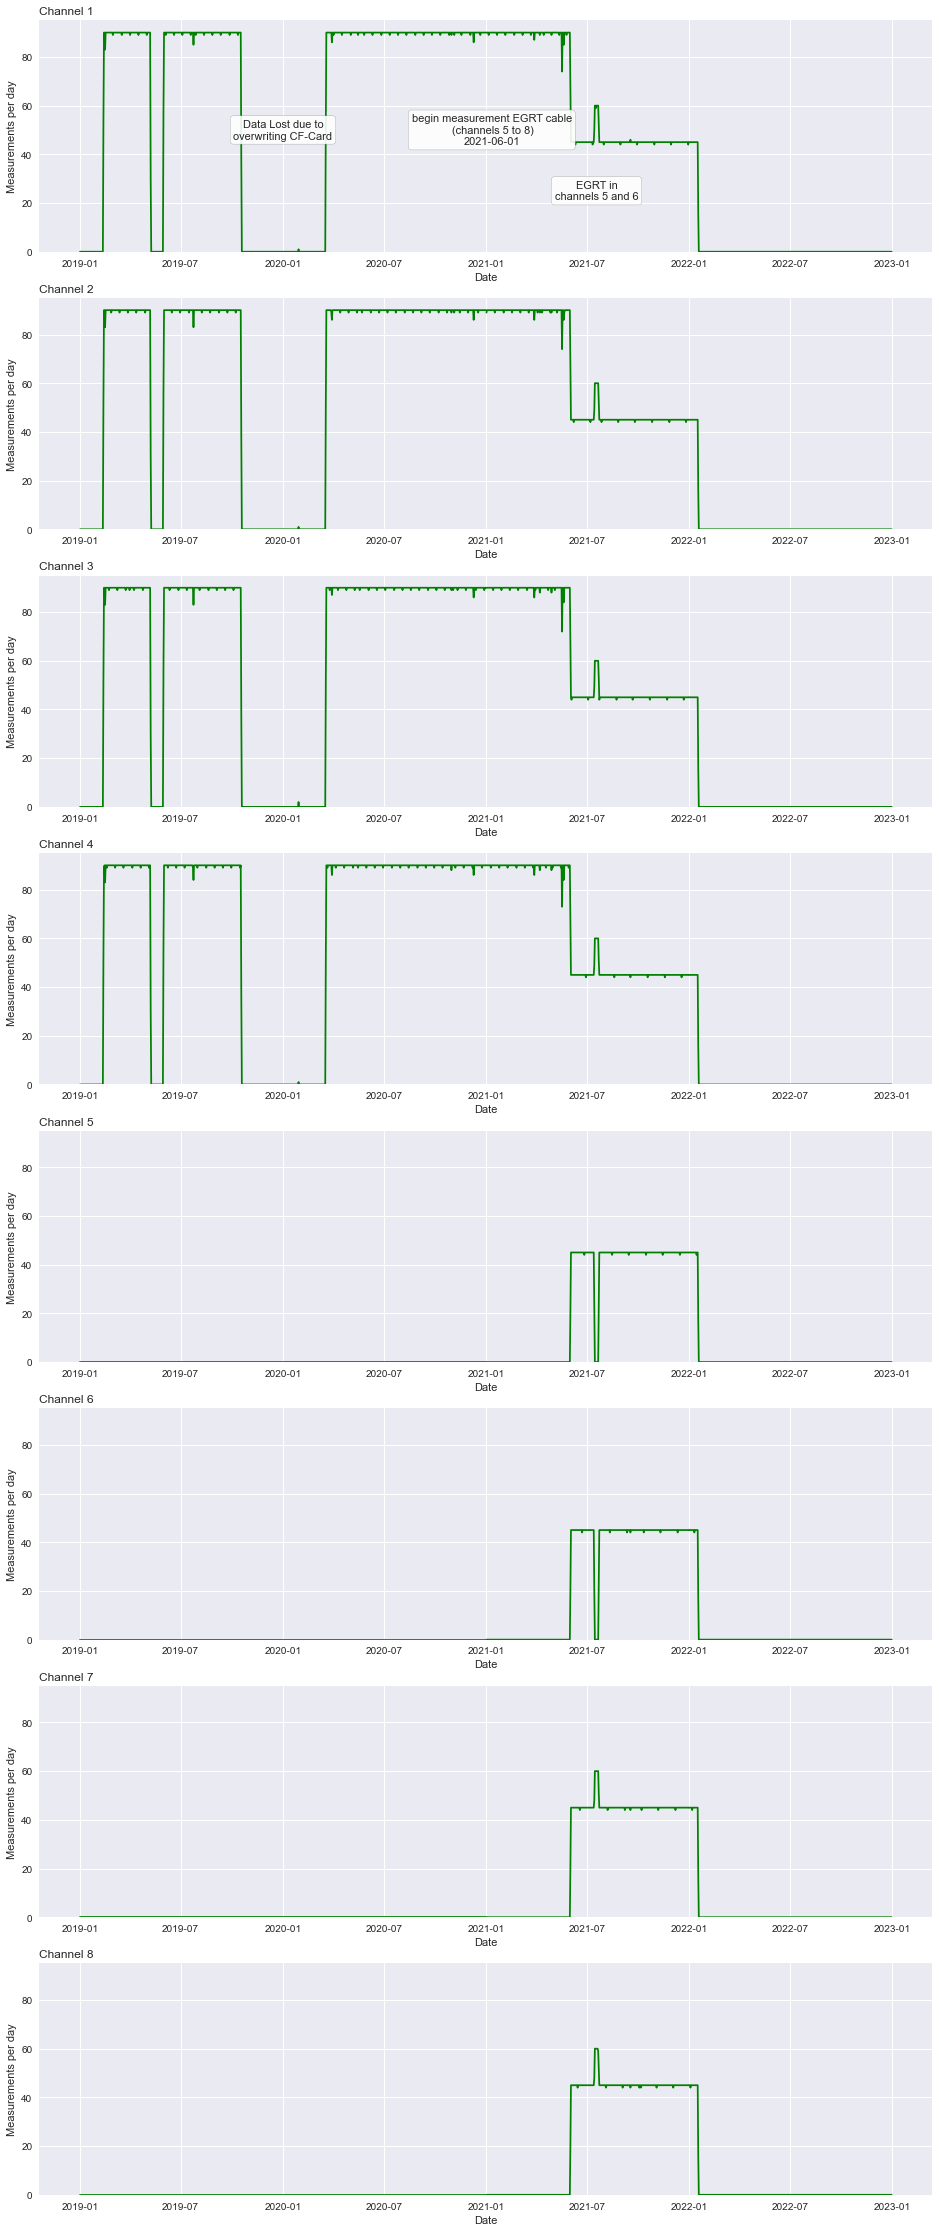

In [11]:
# Plot each channel seperate

# when plotting all different channels in one plot using a loop, this cycler is handy
#from cycler import cycler
#plt.rc('lines', linewidth=4)
#plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['--', '--', '--', '--'])))

fig,axs=plt.subplots(8,1,figsize=[16,40])
for channel in ["1","2","3","4","5","6","7","8"]:
    n=int(channel)-1
    c="green"
    for year in data_seperated_by_year.keys():
        if year!="2018": #treated seperatly further down
            axs[n].plot(pd.to_datetime(list(n_meas_pday_with0[year][channel])), n_meas_pday_with0[year][channel].values(),color=c)

    axs[n].set_ylabel("Measurements per day")
    axs[n].set_xlabel("Date")
    axs[n].set_title(f"Channel {channel}", loc="left")
    axs[n].set_ylim([0,95])
#axs.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']) + cycler('lw', [1, 2, 3, 4]))

# PLOT ACCESSOIREs, Plot Patches with description
## some generel settings
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
x=mdates.date2num(pd.to_datetime("01.01.2020"))
axs[0].text(x, y,"Data Lost due to\noverwriting CF-Card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box
# EGRT Test Channel 5 and 6: 14.07. bis 21.07.
x=mdates.date2num(pd.to_datetime("14.07.2021") + timedelta(days=4))
y=25
axs[0].text(x, y,"EGRT in\nchannels 5 and 6", ha=ha, va=va, size=size, bbox=bbox_props)
y=50
# Add Patch at begin of measurement of EGRT cable (channel 5-8)
#x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')) #date of first measurement of EGRT Cable
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')- timedelta(days=142)) 
axs[0].text(x, y,"begin measurement EGRT cable\n (channels 5 to 8)\n2021-06-01", ha=ha, va=va, size=size, bbox=bbox_props)

if plot_save:
    plot_save_func("all_channels_measpday")
plt.show()

# 90 Messungen pro Tag pro Channel is maximum: 24*60*60/45/8 = 240 s Mittelungszeitraum einer Messung
# 24*60*60: Sekunden pro Tag
# 45: Messungen pro Tag
# 8: Channel in denen gemessen wird

# 2018 data measurements per day plots

In [12]:
# difference to other years:
# different cable length exists --> they have there own key in dic
# column names are not int; due to sampling interval of 0.5 m in some cable length

if plot_2018_data:
    # count meas per day variables for 2018
    n_meas_pday_2018={}
    n_meas_pday_2018_with0={}
    for cable_type in data_seperated_by_year["2018"].keys():
        n_meas_pday_2018[cable_type]       = calculate_measurements_per_day(data_seperated_by_year["2018"][cable_type])
        n_meas_pday_2018_with0[cable_type] = improve_n_meas_pday(n_meas_pday_2018[cable_type], year=2018)


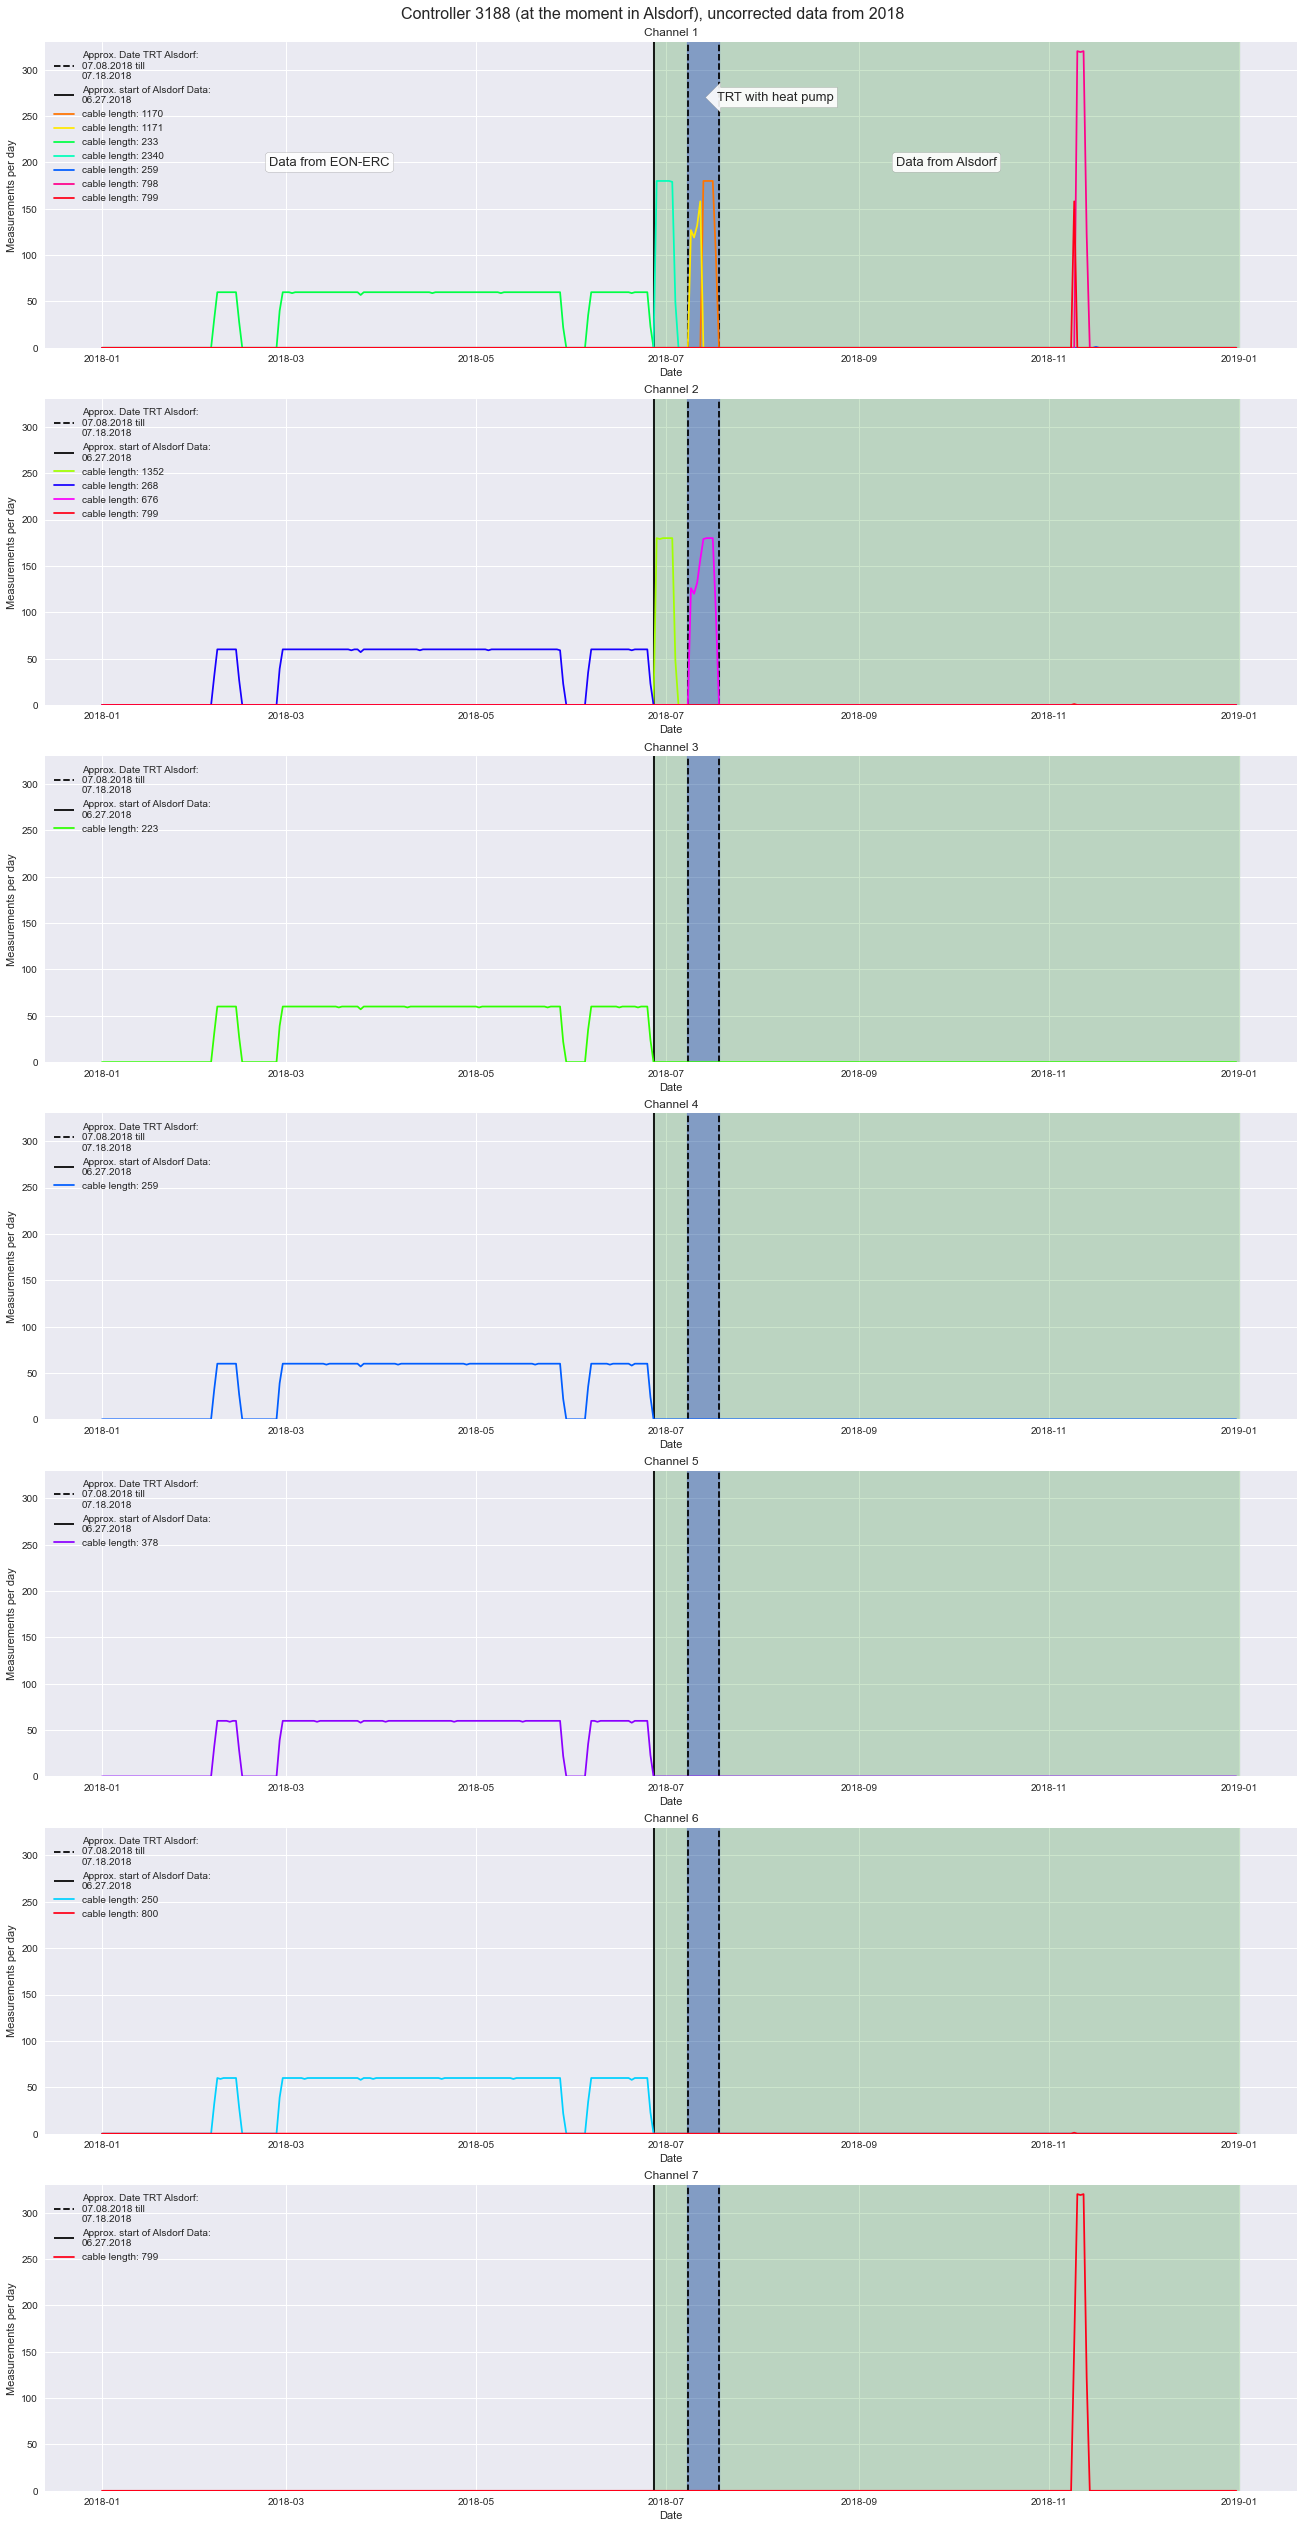

Cable length 2340 and 1352 have a measuring interval of 0.5 m; all other a interval of 1 m
Both of these are shortly before the TRT at 9-10 Juli 2018 (info from Norbert)
All data before should be from EON-ERC (rather a guess). This means data before 27.06.2018


In [13]:
# Plot 2018 data
# Plot each channel seperate
if plot_2018_data:
    def get_cmap(n, name='hsv'):
        '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
        RGB color; the keyword argument name must be a standard mpl colormap name.'''
        return plt.cm.get_cmap(name, n)

    fig,axs=plt.subplots(7,1,figsize=[18,35],constrained_layout=True)
    fig.suptitle("Controller 3188 (at the moment in Alsdorf), uncorrected data from 2018", fontsize=16)
    c=get_cmap(len(data_seperated_by_year["2018"].keys())) # number of different cable lengths
    for channel in ["1","2","3","4","5","6","7"]:
        n=int(channel)-1

        axs[n].set_ylim(0,330)
        axs[n].set_ylabel("Measurements per day")
        axs[n].set_xlabel("Date")
        axs[n].set_title(f"Channel {channel}")

        # PLOT ACCESSOIREs
        # Plot date of TRT 9-10 Juli 2018, these somehow mark the first measurements in Alsdorf (info from Norbert)
        s_dat_trt="07.08.2018"
        e_dat_trt="07.18.2018"
        start_time_trt=mdates.date2num(pd.to_datetime(s_dat_trt))
        end_time_trt=mdates.date2num(pd.to_datetime(e_dat_trt))
        width_trt= end_time_trt - start_time_trt
        fancy_box=patches.FancyBboxPatch(xy=[start_time_trt,0],width=width_trt,height=350,color="blue",alpha=0.3,boxstyle='square')
        axs[n].add_patch(fancy_box)
        axs[n].vlines(start_time_trt, ymin=0, ymax=330, label=f"Approx. Date TRT Alsdorf:\n{s_dat_trt} till\n{e_dat_trt}", colors="black",linestyles="--")
        axs[n].vlines(end_time_trt, ymin=0, ymax=330, colors="black",linestyles="--")
        # Plot Approximated beginn of Alsdorf Data
        s_dat_als="06.27.2018"
        start_time_alsd=mdates.date2num(pd.to_datetime(s_dat_als))
        end_time_alsd=mdates.date2num(pd.to_datetime("01.01.2019"))
        width_alsd = end_time_alsd - start_time_alsd
        axs[n].vlines(start_time_alsd, ymin=0, ymax=330, label=f"Approx. start of Alsdorf Data:\n{s_dat_als}", colors="black",linestyles="-")
        fancy_box=patches.FancyBboxPatch(xy=[start_time_alsd,0],width=width_alsd,height=350,color="green",alpha=0.2,boxstyle='square')
        axs[n].add_patch(fancy_box)

        # PLOT MEASUREMENTS PER DAY OF DATA
        counter=0
        for cable_type in data_seperated_by_year["2018"].keys():
            counter+=1
            # only plot data which have at least one measurement
            if max(n_meas_pday_2018_with0[cable_type][channel].values()) > 0: 
                axs[n].plot(pd.to_datetime(list(n_meas_pday_2018_with0[cable_type][channel])), n_meas_pday_2018_with0[cable_type][channel].values(), color=c(counter), label=f"cable length: {cable_type}")
        
        axs[n].legend()

    # Plot Patches only in first axes
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    size=13; y=200; ha="center"; va="center"
    # Plot data which is expected to be from EON-ERC
    start_time_eon=mdates.date2num(pd.to_datetime("12.01.2017"))
    width_eon=start_time_alsd - start_time_eon
    x = start_time_eon + 0.5 * width_eon
    axs[0].text(x, y,"Data from EON-ERC", ha=ha, va=va, size=size, bbox=bbox_props)
    x = start_time_alsd + 0.5 * width_alsd
    axs[0].text(x, y,"Data from Alsdorf", ha=ha, va=va, size=size, bbox=bbox_props)
    bbox_props = dict(boxstyle="larrow", fc="w", ec="0.5", alpha=0.9)
    x = end_time_trt + 1.8* width_trt
    axs[0].text(x, 270,f"TRT with heat pump", ha=ha, va=va, size=size, bbox=bbox_props)

    if plot_save:
        plot_save_func("all_channels_measpday_2018")
    plt.show()

    print("Cable length 2340 and 1352 have a measuring interval of 0.5 m; all other a interval of 1 m")
    print("Both of these are shortly before the TRT at 9-10 Juli 2018 (info from Norbert)")
    print("All data before should be from EON-ERC (rather a guess). This means data before 27.06.2018")

# Checks
## additional implementions
* [ ] check if pickle and csv data are perfectly equal (also regarding the format)
* [ ] Check if cable length changes 
* [ ] take a closer look at 2018 data

In [14]:
# Data Check
# Check number of nan
if check == True:
    # number of nan
    for channel in data_all.keys():
        for column in data_all[channel].columns:
            n_nan=sum(data_all[channel][column].isna()) # number of nan in column
            if n_nan > 0:
                isna=data_all[channel][column].isna() # column with nan
                dates_isna=isna[isna == True].index
                print(f"number of nan values in channel {channel} at length {column}: {n_nan}")
                print("at the following dates:")
                print(dates_isna)
                print()

# Channel 3 contains nan values at one length
# Channel 7 contains nan values at one length

number of nan values in channel 3 at length 1314: 57724
at the following dates:
DatetimeIndex(['2019-07-24 11:00:09', '2019-07-24 11:16:10',
               '2019-07-24 11:32:10', '2019-07-24 11:48:11',
               '2019-07-24 12:04:12', '2019-07-24 12:20:13',
               '2019-07-24 12:36:13', '2019-07-24 12:52:14',
               '2019-07-24 13:08:15', '2019-07-24 13:24:15',
               ...
               '2022-01-17 03:38:46', '2022-01-17 04:10:48',
               '2022-01-17 04:42:49', '2022-01-17 05:14:51',
               '2022-01-17 05:46:52', '2022-01-17 06:18:53',
               '2022-01-17 06:50:55', '2022-01-17 07:22:56',
               '2022-01-17 07:54:58', '2022-01-17 08:26:59'],
              dtype='datetime64[ns]', name='Date', length=57724, freq=None)

number of nan values in channel 7 at length 3408: 5482
at the following dates:
DatetimeIndex(['2021-09-17 11:23:35', '2021-09-17 11:55:36',
               '2021-09-17 12:27:38', '2021-09-17 12:59:39',
            